In [1]:
import numpy as np
from numpy import pi, cos, sin, array

In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
np.set_printoptions(precision=4, suppress=True)

In [3]:
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)

## Curve Fitting

In [4]:
input_dbm = array([-10, -5, 0, 5, 10, 15, 20, 25])
output_dbm = array([0, 5.5, 10, 14, 18.5, 21, 21, 21])
ones = np.ones_like(input_dbm)

F = np.column_stack([ones, input_dbm, input_dbm**2, input_dbm**3])
A = np.linalg.inv(F.T@F)@F.T@output_dbm

input_range = np.arange(-10, 25, 0.1)
curve_fit = A[0] + A[1]*input_range + A[2]*input_range**2 + A[3]*input_range**3

A

array([10.1039,  0.9432, -0.01  , -0.0004])

In [5]:
# Solve using numpy
A_prime = np.polyfit(input_dbm, output_dbm, 3)
curve_fit_new = np.polyval(A_prime, input_range)

print(f'Max difference in coeffs: {np.max(A-A_prime[::-1]):.4f}')
print(f'Max difference in curvefit: {np.max(curve_fit - curve_fit_new):.4f}')
A_prime[::-1]

Max difference in coeffs: 0.0000
Max difference in curvefit: -0.0000


array([10.1039,  0.9432, -0.01  , -0.0004])

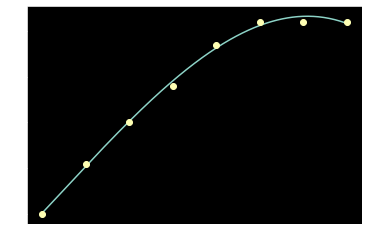

In [6]:
plt.plot(input_range, curve_fit)
plt.plot(input_dbm, output_dbm, 'o');

### Weighted LS

In [7]:
W = np.diag([1, 1, 1, 1, 1, 100, 100, 100])
A_weighted = np.linalg.inv(F.T@W@F)@F.T@W@output_dbm
curve_fit_weighted = A_weighted[0] + A_weighted[1]*input_range + A_weighted[2]*input_range**2 + A_weighted[3]*input_range**3

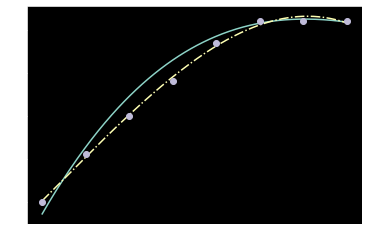

In [8]:
plt.plot(input_range, curve_fit_weighted)
plt.plot(input_range, curve_fit, '-.')
plt.plot(input_dbm, output_dbm, 'o');

## Least Squares Filter Design

In [9]:
N = 17 # taps
freq_index = np.linspace(-(N//2), N//2, N)
freqs = freq_index/N

mag_response = array([.1, .1, .1, .1, .5, 1, 1, 1, 1, 1, 1, 1, .5, .1, .1, .1, .1])
phase_response = np.zeros_like(freqs)

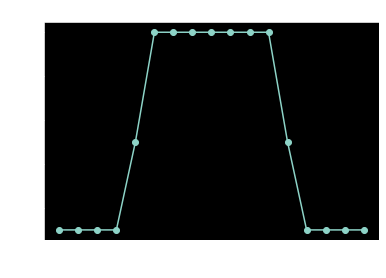

In [10]:
plt.plot(freq_index, mag_response, '-o')
plt.title('Magnitude resonse of desired filter')
plt.xlabel('Discrete Frequency Index')
plt.ylabel('Magnitude');

In [11]:
def IDFT(freqs, H, times):
    h = np.zeros_like(times, dtype=complex)
    for idx, n in enumerate(times):
        tones = np.exp(2j*pi*n*freqs)
        h[idx] = H.dot(tones)
    return h

In [12]:
def DTFT(test_seq, times, freq_resolution=0.001):    
    freqs = np.arange(-0.5, 0.5, freq_resolution)
    
    N = len(test_seq)
    n = times

    dtft = np.zeros_like(freqs, np.complex)
    for idx, freq in enumerate(freqs):
        analysis_tone = np.exp(2j*pi*freq*n)
        dtft[idx] = np.correlate(test_seq, analysis_tone).squeeze()
        
    return dtft, freqs

In [13]:
times = freq_index
h = IDFT(freqs, mag_response, freq_index)
h /= np.abs(h.sum())
h.real

array([-0.0077, -0.0085,  0.0189,  0.0332, -0.0265, -0.0806,  0.0309,
        0.2815,  0.5176,  0.2815,  0.0309, -0.0806, -0.0265,  0.0332,
        0.0189, -0.0085, -0.0077])

In [14]:
continuous = np.arange(-(N//2), N//2, 0.25)
h_continuous = IDFT(freqs, mag_response, continuous)
    
scale = h.max().real/ h_continuous.max().real
h_continuous *= scale

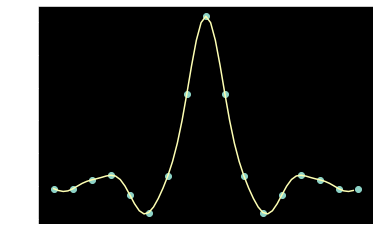

In [15]:
plt.plot(times, h.real, 'o', continuous, h_continuous.real);

#### Alternative Formulation

In [16]:
n = m = freq_index
mn = n * m[:, np.newaxis]
F = np.exp(-2j*pi*mn/N)
h_alt = np.linalg.inv(F)@mag_response
h_alt /= np.abs(np.sum(h_alt))

np.max(np.abs(h - h_alt))

2.3598641192913663e-16

In [17]:
dtft, freq_continuous = DTFT(h, n, 0.01)

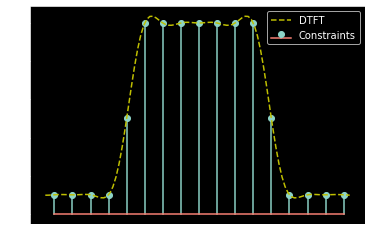

In [18]:
plt.stem(freqs, mag_response, label='Constraints')
plt.plot(freq_continuous, np.abs(dtft), '--y', label='DTFT')
plt.legend();

### Using LS

In [19]:
weights = np.ones_like(freqs)
weights[:4] = 100
W = np.diag(weights)

N = 9
n = np.linspace(-4, 4, N)

M = 17
m = np.linspace(-8, 8, M)

mn = n * m[:, np.newaxis]
F = np.exp(-2j*pi*mn/M)
h = np.linalg.inv(F.T@W@F)@F.T@W@mag_response

h.real, h.imag

(array([-0.0491, -0.0784,  0.0465,  0.2778,  0.5091,  0.2778,  0.0465,
        -0.0784, -0.0491]),
 array([ 0.016 ,  0.0118,  0.0001, -0.0127,  0.    ,  0.0127, -0.0001,
        -0.0118, -0.016 ]))

In [20]:
dtft, freq_continuous = DTFT(h, n, 0.01)

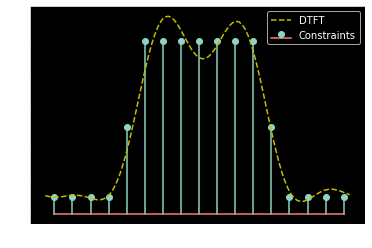

In [21]:
plt.stem(freqs, mag_response, label='Constraints')
plt.plot(freq_continuous, np.abs(dtft), '--y', label='DTFT')
plt.legend();

# Minimax Approximation

In [22]:
step_size = 0.01
endpoints = (0, 4)
x = np.arange(endpoints[0], endpoints[1]+step_size, step_size)
F = 1/(1 + 25*(x**2))

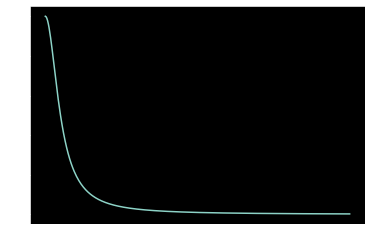

In [23]:
plt.plot(x, F);

In [24]:
N = 5
x_guess = np.linspace(*endpoints, N+2) # Per Chebyshev, N+2 positions have max error
idx = np.searchsorted(x, x_guess) 
x_guess = x[idx] # Refine x_guess to ensure it lies in x
F_guess = F[idx]


In [25]:
error_signs = (-1)**np.arange(N+2).reshape(-1,1)
X = np.vander(x_guess, N+1, increasing=True)
X = np.hstack([X, error_signs])

In [26]:
C = np.linalg.inv(X)@F_guess
coeffs = C[:N+1]
error_estimate = C[-1]
error_estimate.round(4)

0.0108

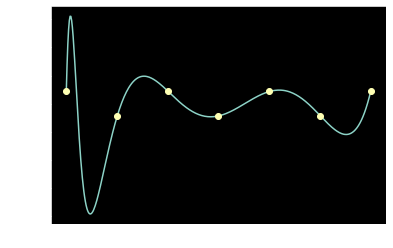

In [27]:
F_est = np.polyval(coeffs[::-1], x)
error = F - F_est

design_errors = error_estimate*error_signs

plt.plot(x, error, x_guess, design_errors,'o');

### Iterative Remez Algorithm

In [28]:
def remez(error, order, prev_idx):
    zero_crossings = np.where(np.diff(np.sign(error)))[0]
    if len(zero_crossings) < (order+1):
        print('Insufficient number of zero crossings. Only {} found'.format(len(zero_crossings)))
        return prev_idx
    elif len(zero_crossings) > (order+1):
        zero_crossings = zero_crossings[:(order+1)]    
    
    split_arrays = np.split(error, zero_crossings+1)
    end_points = np.concatenate(([0], zero_crossings))
    new_indices = []

    for start, section in zip(end_points, split_arrays):
        min_max_idx = np.argmax( np.abs(section) )
        min_max = section[min_max_idx]
        new_indices.append(start+min_max_idx)
    
    return array(new_indices)

Final coeffs : [ 1.05   -3.2551  3.6669 -1.8457  0.4219 -0.0357]


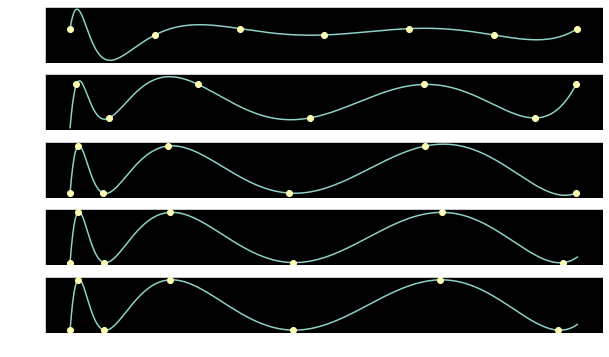

In [29]:
REMEZ_ITER = 5

N = 5
x_guess = np.linspace(*endpoints, N+2) # Per Chebyshev, N+2 positions have max error
idx = np.searchsorted(x, x_guess) 

fig, ax = plt.subplots(REMEZ_ITER, 1, figsize=(10,6))
for c_iter in range(REMEZ_ITER):
    x_guess = x[idx] # Refine x_guess to ensure it lies in x
    F_guess = F[idx]
    
    error_signs = (-1)**np.arange(N+2).reshape(-1,1)
    X = np.vander(x_guess, N+1, increasing=True)
    X = np.hstack([X, error_signs])
    
    C = np.linalg.inv(X)@F_guess
    coeffs = C[:N+1]
    error_estimate = C[-1]
    
    F_est = np.polyval(coeffs[::-1], x)
    error = F - F_est
    
    design_errors = error_estimate*error_signs
    ax[c_iter].plot(x, error, x_guess, design_errors,'o');
    
    idx = remez(error, N, idx)
    
print('Final coeffs : {}'.format(coeffs))

### Equiripple Filter Design

#### Iteration 1

In [30]:
N = 15
constraints = 1+(N+1)//2
freqs = array([0, 0.1, 0.15, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5])
H = np.zeros_like(freqs)
H[freqs<=0.2] = 1
error_signs = array([1, -1, 1, -1, 1, -1, 1, -1, 1])

assert(len(freqs)==constraints)
assert(len(error_signs)==constraints)

In [31]:
taps = np.arange(7, -1, -1)
cols = 2*cos(2*pi*freqs[:, np.newaxis]*taps)
cols[:, -1] /= 2 # The last col should not be multiplied by 2 (tap 0)
X = np.hstack([cols, error_signs.reshape(-1, 1)])

c_and_e = np.linalg.inv(X)@H
coeffs = c_and_e[:-1]
error = c_and_e[-1]

In [32]:
filter_coeffs = np.concatenate([coeffs[:-1], coeffs[::-1]])

array([-0.0226,  0.001 ,  0.05  ,  0.0015, -0.0954,  0.0025,  0.318 ,
        0.5025,  0.318 ,  0.0025, -0.0954,  0.0015,  0.05  ,  0.001 ,
       -0.0226])

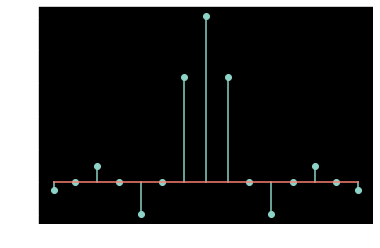

In [33]:
plt.stem(filter_coeffs)
filter_coeffs

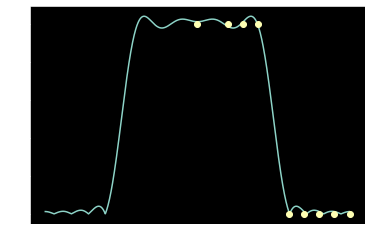

In [34]:
freq_response, freq_continuous = DTFT(filter_coeffs, np.arange(-7, 8), freq_resolution=0.001)
plt.plot(freq_continuous, np.abs(freq_response))
plt.plot(freqs, H, 'o');

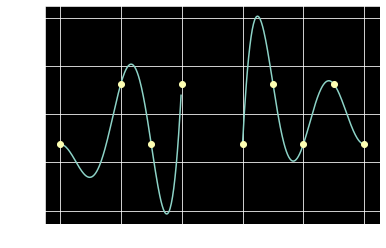

In [35]:
pos_freqs = freq_continuous[freq_continuous >= 0]
pos_response = freq_response[freq_continuous >= 0]

desired_response = np.ones_like(pos_freqs)
desired_response[pos_freqs >= 0.3] = 0
error_curve =  desired_response - pos_response.real 
error_curve[(pos_freqs > 0.2) & (pos_freqs < 0.3)] = None

design_errors = error*error_signs

plt.plot(pos_freqs, error_curve,
         freqs, design_errors, 'o')
plt.grid()

#### Iteration 2

In [36]:
freqs = array([0.05, 0.11, 0.18, 0.2, 0.3, 0.32, 0.38, 0.44, 0.5])
H = np.zeros_like(freqs)
H[freqs<=0.2] = 1

In [37]:
taps = np.arange(7, -1, -1)
cols = 2*cos(2*pi*freqs[:, np.newaxis]*taps)
cols[:, -1] /= 2 # The last col should not be multiplied by 2 (tap 0)
X = np.hstack([cols, error_signs.reshape(-1, 1)])

c_and_e = np.linalg.inv(X)@H
coeffs = c_and_e[:-1]
filter_coeffs = np.concatenate([coeffs[:-1], coeffs[::-1]])

error = c_and_e[-1]

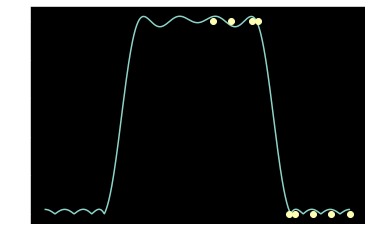

In [38]:
freq_response, freq_continuous = DTFT(filter_coeffs, np.arange(-7, 8), freq_resolution=0.001)
plt.plot(freq_continuous, np.abs(freq_response))
plt.plot(freqs, H, 'o');

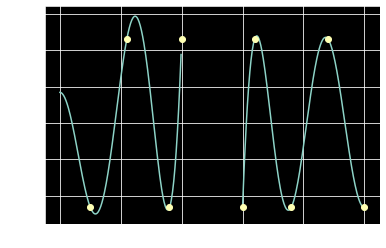

In [39]:
pos_freqs = freq_continuous[freq_continuous >= 0]
pos_response = freq_response[freq_continuous >= 0]

desired_response = np.ones_like(pos_freqs)
desired_response[pos_freqs >= 0.3] = 0
error_curve =  desired_response - pos_response.real 
error_curve[(pos_freqs > 0.2) & (pos_freqs < 0.3)] = None

design_errors = error*error_signs

plt.plot(pos_freqs, error_curve,
         freqs, design_errors, 'o')
plt.grid()

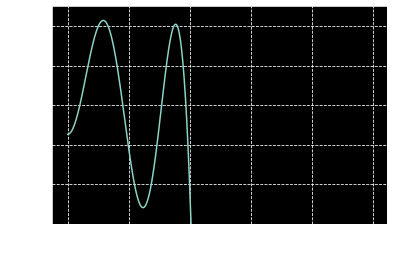

In [40]:
plt.plot(pos_freqs, 20*np.log10(np.abs(pos_response)) ) 
plt.ylim((-0.3, 0.25))
plt.grid(linestyle='dashed')
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude reponse (dB)');

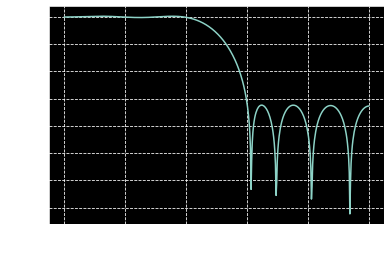

In [41]:
plt.plot(pos_freqs, 20*np.log10( np.abs(pos_response)) ) 
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude reponse (dB)')
plt.grid(linestyle='dashed');

# Interpolation

## Polynomials

In [42]:
X = array([0, 1, 2, 3]) 
Y = array([1, 3, 2, 2])

x = 1.5 # The x-coordinate where we want to interpolate

#### Algebraic form

In [43]:
F = np.vander(X, 4, increasing=True) # x^0...x^3
A = np.linalg.inv(F)@Y
y_algebraic = A.dot(array([1, x, x**2, x**3]))

y_algebraic.round(3)

2.625

#### Lagrange form

In [44]:
b = np.zeros_like(Y, float)
b[0] = (-1/6)*(x-1)*(x-2)*(x-3)
b[1] = (1/2)*x*(x-2)*(x-3)
b[2] = (-1/2)*x*(x-1)*(x-3)
b[3] = (1/6)*x*(x-1)*(x-2)

y_lagrange = b.dot(Y)
y_lagrange

2.625

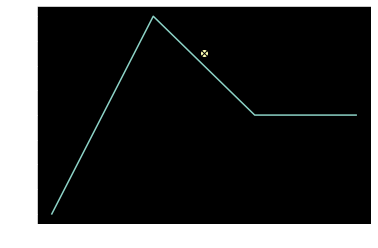

In [45]:
plt.plot(X, Y, x, y_lagrange, 'o', x, y_algebraic, 'kx');

# Multirate Signal Processing

## The Half-Band Filter

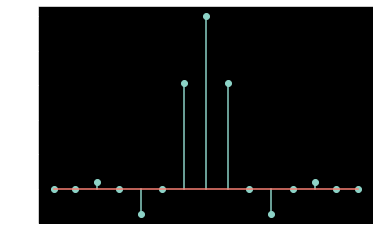

In [46]:
taps = 15
N = taps
n = np.arange(taps)
sinc_points = n/2 - (N-1)/4
hanning = np.ones_like(n) - cos(2*pi*(n+1)/(N+1))

# Half band filter impulse response
h = np.sinc(sinc_points) * hanning
h /= np.abs(h.sum())

plt.stem(n, h);

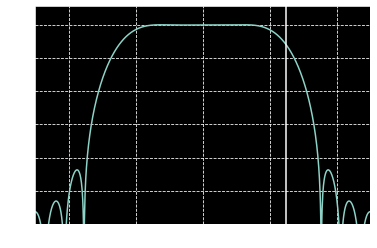

In [47]:
H, freqs = DTFT(h, n)
plt.plot(freqs, 20*np.log10( np.abs(H) ))
plt.axvline(x=0.25)
plt.ylim(bottom = -60)
plt.xlim((-.5, .5))
plt.grid(linestyle='dashed');